In [263]:
import pandas as pd
import numpy as np
import random
from utils import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [2]:
df = pd.read_csv('data.csv')

In [283]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
df['TIME_DEVIATION'] = df['CalcHours'] - df['Hours']
KDEY = clusterKDE(df['TIME_DEVIATION'])
DBSCANY = clusterDBSCAN(df['TIME_DEVIATION'])

# OPTICS
clust = OPTICS(max_eps=4, min_samples=5, xi=0.1, min_cluster_size=.05)
targets = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
clust.fit(targets)
OPTICSY = clust.labels_

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=6, covariance_type='spherical')
targets = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
gmm.fit(targets)
GMMY = gmm.predict(targets)

# Kmeans
kmeans = KMeans(n_clusters=5).fit(targets)
KmeansY = kmeans.labels_

df['cluster'] = DBSCANY
timeX = data.loc[:]

/Users/Mr_ren/.virtualenvs/thesis/lib/python3.8/site-packages/sklearn/cluster/_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [273]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, DBSCANY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, DBSCANY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, DBSCANY))

Silhouette Coefficient 0.8620279028894456
Calinski-Harabasz Index 69.37154221180448
Davies-Bouldin Index 1.9432758337489442


In [274]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, OPTICSY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, OPTICSY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, OPTICSY))

Silhouette Coefficient -0.09416026284853614
Calinski-Harabasz Index 0.15248368976449425
Davies-Bouldin Index 5.375237414055704


In [275]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, GMMY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, GMMY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, GMMY))

Silhouette Coefficient 0.6257490937552842
Calinski-Harabasz Index 10920.394161056865
Davies-Bouldin Index 0.6328473194982859


In [276]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, KDEY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, KDEY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, KDEY))

Silhouette Coefficient -0.42064524081097016
Calinski-Harabasz Index 10.667491080182977
Davies-Bouldin Index 1.0312477936042566


In [277]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, KmeansY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, KmeansY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, KmeansY))

Silhouette Coefficient 0.9322873232749874
Calinski-Harabasz Index 37962.03679679715
Davies-Bouldin Index 0.22077407257359552


In [284]:
timeY = KmeansY

In [285]:
Counter(timeY)

Counter({0: 1045, 2: 11, 1: 3, 4: 30, 3: 7})

In [280]:
timeModel = svm.SVC(class_weight='balanced')

In [286]:
oversampleRates = [i / 10 for i in range(4, 11)]

for rate in oversampleRates:
    timeSampleDict = getSampleDict(timeY, overSampleRate=rate)
    timePipeline = getResamplePipeline(timeSampleDict, k_neighbors=2, withUnder=True)
    timeX_res, timeY_res = timePipeline.fit_resample(timeX, timeY)
    print('Sample rate {0}, Accuracy {1}'.format(rate, crossValidate(timeModel, timeX_res, timeY_res, 3, 3)))

Sample rate 0.4, Accuracy 0.9451705230165294
Sample rate 0.5, Accuracy 0.9333953460326687
Sample rate 0.6, Accuracy 0.9424515365501995
Sample rate 0.7, Accuracy 0.9380608475097583
Sample rate 0.8, Accuracy 0.9439527061720118
Sample rate 0.9, Accuracy 0.9436187961183572
Sample rate 1.0, Accuracy 0.949681241892383


<AxesSubplot:xlabel='Time hours', ylabel='Frequency'>

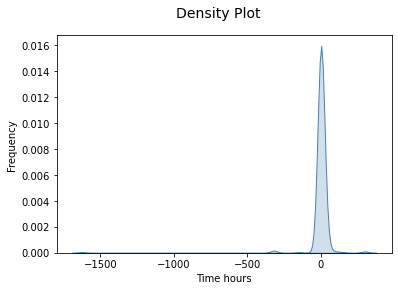

In [76]:
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Density Plot", fontsize=14)
# fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,1, 1)
ax1.set_xlabel("Time hours")
ax1.set_ylabel("Frequency") 
sns.kdeplot(df['TIME_DEVIATION'], ax=ax1, shade=True, color='steelblue')

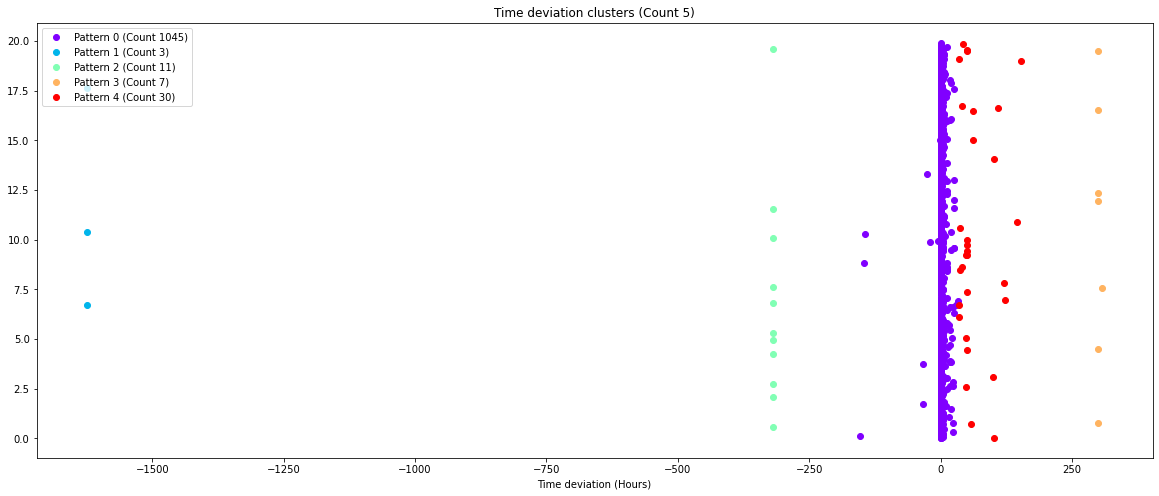

In [287]:
fig, ax = plt.subplots(figsize = (20, 8))
colors = cm.rainbow(np.linspace(0, 1, len(Counter(timeY))))
n_clusters = len(Counter(timeY))
df['cluster'] = timeY
for i, cluster in df.groupby('cluster'):
    y = []
    for _ in range(len(cluster['TIME_DEVIATION'])):
        y.append(random.random() * 20)
    label = 'Outlier' if i == -1 else 'Pattern ' + str(i)
    label += " (Count {0})".format(len(y))
    _ = ax.scatter(cluster['TIME_DEVIATION'], y, color=colors[i], label=label)

ax.legend(loc="upper left")
ax.set_title('Time deviation clusters ' + '(Count {})'.format(n_clusters))
ax.set_xlabel('Time deviation (Hours)')
plt.show()